In [1]:
import glob
import numpy as np
import pandas as pd 
from collections import defaultdict
from math import isclose
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy.stats


def conf_int(data, axis=0, alpha=0.95):
    return scipy.stats.sem(data, axis=axis) * scipy.stats.t.ppf((1 + alpha) / 2., data.shape[axis]-1)


/home/gabrihacker/.virtualenvs/truenets_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  if __name__ == "__main__":


In [2]:
#Load DTM
import rasterio as rio
import csv
import shapely.wkt as wkt
from rasterio import mask, features

dtms = {}
max_dist =  300
for a in ['firenze', 'trento', 'napoli']:
    with open(f'{a}.csv') as sacsv:
        subareas_csv = list(csv.reader(sacsv, delimiter=','))
    dataset = rio.open(f'/home/gabrihacker/data/dtm_fusion/{a}_dtm.tif')
    for sa in subareas_csv:
        sa_id = sa[1]
        sa_wkt = sa[0]
        sub_area = wkt.loads(sa_wkt)
        buffered_area = sub_area.buffer(max_dist/2)
        dataset_crop, rm_transform = rio.mask.mask(dataset, [buffered_area], crop=True, indexes=1)
        dtms[(a,sa_id)] = dataset_crop
        


In [7]:
runs = glob.glob('/home/gabrihacker/TNSM2022/results_rebuttal/*/*/*/*/*/*/*/')
runs = glob.glob('/home/gabrihacker/TNSM2022/results_rebuttal/*/threestep/*/*/*/*/*/')


bad = 0
good = 0
results = []
for r in runs[:]:
    max_angles = []
    min_distances = []
    prefix, subpath = r.split('results_rebuttal')
    params =  subpath.split('/')
    area, strat, sa, rf, k, ratio, dens = params[1:-1]

    bp = prefix+'results_rebuttal'+'/'.join(params[:4])
    invmat = np.load(f'{bp}/inverse_translation_matrix.npy')
    viewsheds = np.load(f'{r}/viewsheds.npy')
    nodes = pd.read_csv(f'{r}/index.csv', 
                        sep=' ', 
                        header=0, 
                        names=['x', 'y', 'z', 'x_3003', 'y_3003', 'b', 'p_i']
                        ).set_index('p_i')
    links = np.argwhere(viewsheds) #get ones from the viewshed
    nodes_dict = {}
    for n in nodes.index:
        pn = nodes.loc[n]
        nodes_dict[n] = np.array([pn.x, pn.y, pn.z])

    #create a dict with a list of bs that sees a point
    adjdict = defaultdict(list)
    for l in links:
        ant = l[1]
        p = l[0]
        if ant in nodes.index:
            adjdict[p].append(nodes_dict[ant])

    for p in adjdict.keys():
        loc = invmat[p]
        dists = []
        angles = []
        vectors = []
        for bs_loc in adjdict[p]:
            loc_z = dtms[(area, sa)][loc[0], loc[1]]
            if loc_z >= 0:
                loc_3d = np.array([loc[0], loc[1], loc_z])
                v = bs_loc-loc_3d
                vectors.append(v)
                dists.append(np.linalg.norm(v))
                angles.append(float(np.degrees(np.arctan2(v[0], v[1])))) #cast to int to avoid errors
        if not vectors:
            bad +=1
        else:
            good +=1
            angles.sort()      
            angles.append(angles[0])  ##Trick to create a ring
            angles = np.array(angles) #convert to n[0], vector[1]umpy
            diffs = (angles[1:] - angles[:-1]) % 360  #modulo 360 to get positive  angles
            assert(isclose(sum(diffs),360) or isclose(sum(diffs),0))

            result = {}
            result['sa'] = sa
            if rf == 'r1' and k=='1':
                result['scoring'] = '1-CM'
            elif rf == 'r1' and k=='3':
                result['scoring'] = '3-CM'
            elif rf == 'rlc' and k=='3':
                result['scoring'] = '3-CG'
            elif rf == 'fi'  and k=='3':
                result['scoring'] = '3-CF'
            elif rf == 'r2' and k=='3':
                result['scoring'] = '3-CM2'
            
            result['ratio'] = float(ratio)
            result['dens'] =int(dens)
            result['max_angle'] = diffs.max()
            result['min_distance'] = np.array(dists).min(axis=0)
            result['ncov'] = len(adjdict[p])
            # result['vectors'] = vectors
            # result['angles'] = angles[:-1]
            results.append(result)

print(bad, good)
results = pd.DataFrame(results)
results.to_pickle('/home/gabrihacker/TNSM2022/results_rebuttal/postprocess')

32998 67345721


In [3]:
results = pd.read_pickle('/home/gabrihacker/TNSM2022/results_rebuttal/postprocess')

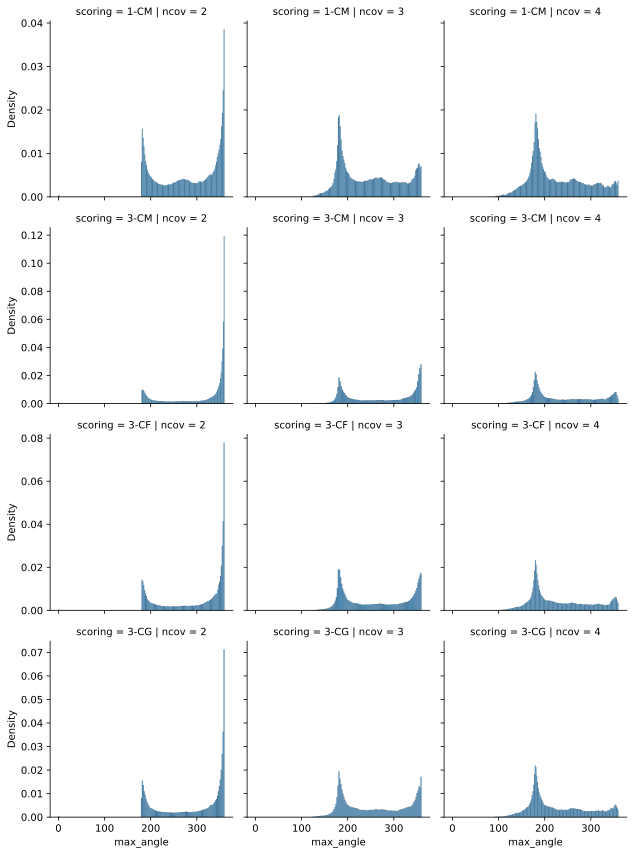

In [4]:

g = sns.FacetGrid(results[(results.ncov > 1) & (results.ncov <5) & (results.scoring != '3-CM2')], col="ncov",  row="scoring", sharey='row')
g.map_dataframe(sns.histplot, x='max_angle', stat='density')


Generate Synthetical Angles

In [11]:
synth_results = []
sample_size = 1000000
max_ncov=10
for ndx, ncov in enumerate(range(2,max_ncov)):
    angles = np.zeros(shape=(sample_size, ncov+1))
    random_angles = np.random.rand(sample_size, ncov)*360
    random_angles.sort(axis=1)
    angles[:, :-1] = random_angles
    angles[:,-1] = angles[:,0]
    diffs = (angles[:, 1:]- angles[:, :-1])%360
    max_angles = diffs.max(axis=1)
    for m in max_angles:
        result = {}
        result['scoring'] = 'Synth'
        result['sa'] = -1
        result['ratio'] = 0
        result['dens'] = 0
        result['max_angle'] = m
        result['min_distance'] = 0
        result['ncov'] = ncov
        synth_results.append(result)
    
synth_results = pd.DataFrame(synth_results)

In [ ]:

g = sns.FacetGrid(synth_results[(synth_results.ncov > 1) & (synth_results.ncov <10)], col="ncov", sharey='row', col_wrap=3)
g.map_dataframe(sns.histplot, x='max_angle', stat='density')


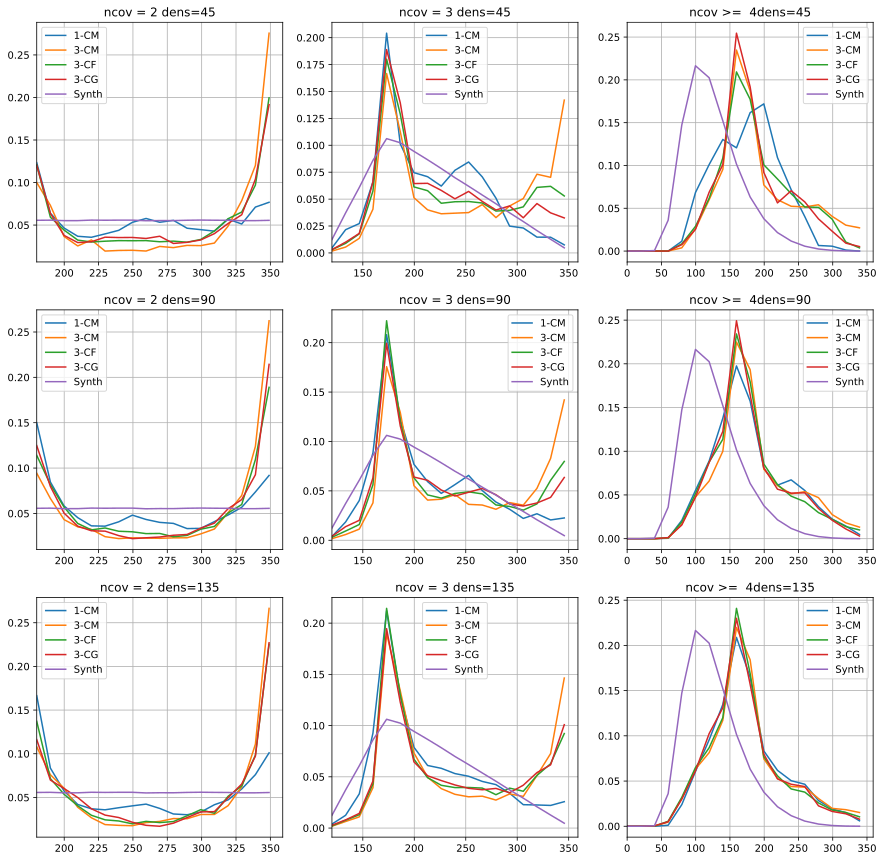

In [12]:
max_ncov = 4
myresults = results[results.ratio==100.0]
plt.figure(figsize=(15,15))
for ddx, dens in enumerate(sorted(map(int, myresults.dens.unique()[:]))):
    for ndx, ncov in enumerate(range(2,max_ncov+1)):
        ax = plt.subplot(3,3,1+ndx+ddx*3)
        if ncov==max_ncov: # use >=
            filter = myresults.ncov>=ncov
            synth_filter =  synth_results.ncov>=ncov+1
            ax.set_title(f'ncov >=  {ncov}dens={dens}')
            rang = (0,359)
        else:
            filter= myresults.ncov==ncov
            synth_filter =  synth_results.ncov==ncov
            ax.set_title(f'ncov = {ncov} dens={dens}')
            rang = (360/ncov,359)
            
        for score in myresults[(myresults.scoring != '3-CM2')].scoring.unique():
            vals = myresults[(filter) & (myresults.scoring == score)& (myresults.dens==dens)].max_angle
            y, bins = np.histogram(vals, bins=18, range=rang)
            y=y/sum(y)
            ax.plot(bins[:-1], y, label=score)
        
        vals = synth_results[(synth_filter)].max_angle
        y, bins = np.histogram(vals, bins=18, range=rang)
        y=y/sum(y)
        ax.plot(bins[:-1], y, label='Synth')
        
        ax.set_xlim([rang[0],rang[1]])
        ax.grid()
        ax.legend()

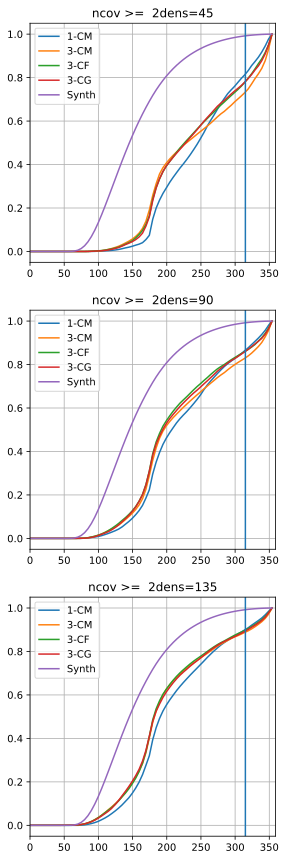

In [19]:
max_ncov = 2
myresults = results[results.ratio==4.0]
plt.figure(figsize=(15,15))
for ddx, dens in enumerate(sorted(map(int, myresults.dens.unique()[:]))):
    for ndx, ncov in enumerate(range(2,max_ncov+1)):
        ax = plt.subplot(3,3,1+ndx+ddx*3)
        if ncov==max_ncov: # use >=
            filter = myresults.ncov>=ncov
            synth_filter =  synth_results.ncov>=ncov+1
            ax.set_title(f'ncov >=  {ncov}dens={dens}')
            rang = (0,359)
        else:
            filter= myresults.ncov==ncov
            synth_filter =  synth_results.ncov==ncov
            ax.set_title(f'ncov = {ncov} dens={dens}')
            rang = (360/ncov,359)
            
        for score in myresults[(myresults.scoring != '3-CM2')].scoring.unique():
            vals = myresults[(filter) & (myresults.scoring == score)& (myresults.dens==dens)].max_angle
            y, bins = np.histogram(vals, bins=72, range=rang)
            y=y/sum(y)
            ecdf = [sum(y[:i+1]) for i in range(len(y))]
            ax.plot(bins[:-1], ecdf, label=score)
        
        vals = synth_results[(synth_filter)].max_angle
        y, bins = np.histogram(vals, bins=72, range=rang)
        y=y/sum(y)
        ecdf = [sum(y[:i]) for i in range(len(y))]
        ax.plot(bins[:-1], ecdf, label='Synth')
        
        ax.axvline(x=315)

        ax.set_xlim([rang[0],rang[1]])
        ax.grid()
        ax.legend()

**Definitive Metric for Gnuplot**

In [11]:
myresults = results[(results.ratio==4.0) & (results.scoring != '3-CM2') &(results.dens.isin(['45','75','105','135']))]

scores = myresults.scoring.unique()
denss = sorted(map(int, myresults.dens.unique()))
gnuplot_meaned = np.zeros(shape=(len(denss), 3))
gnuplot = np.zeros(shape=(len(denss), len(scores)+1))
labels =  ['dens', '1-CM', '3-CM', '3-CF', '3-CG']
for ddx, dens in enumerate(denss):
    metrics = np.zeros(shape=(len(scores)))
    gnuplot[ddx, 0] = dens
    for sdx, score in enumerate(scores):
        vals = myresults[(myresults.ncov>=2) & (myresults.scoring == score)& (myresults.dens==dens)].max_angle
        y, bins = np.histogram(vals, bins=359, range=(0,359))
        y=y/sum(y)
        metrics[sdx] = sum(y[:316])
        gnuplot[ddx, sdx+1] = metrics[sdx]
    gnuplot_meaned[ddx, 0] = int(dens)
    gnuplot_meaned[ddx, 1] = np.mean(metrics)
    gnuplot_meaned[ddx, 2] = conf_int(metrics)
np.savetxt('/home/gabrihacker/TNSM2022/results_rebuttal/covered_angle_315.csv', gnuplot, header=' '.join(labels))
np.savetxt('/home/gabrihacker/TNSM2022/results_rebuttal/covered_angle_315.csv_u', gnuplot_meaned)
        

In [17]:
myresults = results[(results.scoring != '3-CM2') & (results.ratio==4.0) & (results.dens.isin(['45','75','105','135']))]
gnuplot = np.zeros(shape=(299, len(results.dens.unique())+1))
gnuplot[:, 0] = np.linspace(0,300,300)[:-1]
labels = ['x']
for ddx, dens in enumerate(sorted(map(int, myresults.dens.unique()))):
    y, bins = np.histogram(myresults[(myresults.dens == dens)].min_distance, bins=range(0,300), range=(0,300))
    y=y/sum(y)
    ecdf = [sum(y[:i+1]) for i in range(len(y))]
    gnuplot[:, ddx+1] = ecdf
    labels.append(f'{dens}')
np.savetxt('/home/gabrihacker/TNSM2022/results_rebuttal/link_lenght_ecdf.csv', gnuplot, header=' '.join(labels))